In [1]:
# Plenty of other people have done this exact thing on this exact dataset.  I'm not going to reinvent the wheel.
# My job here is to bring together two different analyses and hopefully get something better than the sum of it's parts.
# Instead of pointlessly rehashing work others have done better, I have looked through the ~20 other code projects
# on this dataset, selected the best one, and will apply it here.

In [1]:
# First Model: BERT
!pip install transformers
!pip install accelerate 
!pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets
!pip install pandas-profiling[notebook]

  Cloning https://github.com/huggingface/accelerate to c:\users\kevin\appdata\local\temp\pip-req-build-mihfg013
  Resolved https://github.com/huggingface/accelerate to commit 3e14dd16bec6a7e2b63bb4db409a3aebff186cb9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


  Running command git clone -q https://github.com/huggingface/accelerate 'C:\Users\Kevin\AppData\Local\Temp\pip-req-build-mihfg013'


  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached pydantic-1.9.0-cp39-cp39-win_amd64.whl (2.1 MB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached phik-0.12.2-cp39-cp39-win_amd64.whl (685 kB)
  Using cached missingno-0.5.1-py3-none-any.whl (8.7 kB)
  Using cached tangled_up_in_unicode-0.1.0-py3-none-any.whl (3.1 MB)
  Using cached visions-0.7.4-py3-none-any.whl (102 kB)
  Using cached multimethod-1.8-py3-none-any.whl (9.8 kB)
  Using cached htmlmin-0.1.12-py3-none-any.whl
  Using cached ImageHash-4.2.1-py2.py3-none-any.whl
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [6]:
!pip install xgboost
!pip install lightgbm
!pip install wordcloud
!pip install emoji
!pip install tenserflow
!pip install sentencepiece

ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import load_metric, Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import emoji
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
# Setting up the model hyperparameters

def model_config():
    cfg_dictionary = {
        "data_path": "sentiments.csv",
        "model_path": "models/bert_model.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 5,
        "adam_epsilon": 1e-8,
        "lr": 3e-5,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

In [4]:
# We define a regime of cleaning steps that remove URL's, Emoji's, Special Characters that appear very infrequenty.
def clean_text(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df 
    
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've', 
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                      'de', 're', 'amp', 'will'])
    
def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(emoji.get_emoji_regexp(),"",text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text

In [5]:
def preprocess_csv(csv_file: str) -> pd.DataFrame:
    df = pd.read_csv(csv_file)

    labelencoder = LabelEncoder()
    df["label_enc"] = labelencoder.fit_transform(df["Sentiment"])
    df.rename(columns={"label": "label_desc"}, inplace=True)
    df.rename(columns={"label_enc": "labels"}, inplace=True)
    df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)

    cleaned_df = clean_text(df, "Sentence")
    
    if cfg.model_type is not "transformer":
        cleaned_df["Sentence"] = cleaned_df["Sentence"].apply(preprocess_text)
    return cleaned_df

In [2]:
#Pandas profiling helps us evaluate our data in one single command.
df = preprocess_csv(cfg.data_path)
profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

NameError: name 'preprocess_csv' is not defined

In [7]:
def create_dataset(dataframe):
    training_df, test_df = train_test_split(
        dataframe,
        test_size=cfg.test_size,
        random_state=cfg.random_seed,
        stratify=dataframe.labels.values,
    )
    train_df, val_df = train_test_split(
        training_df,
        test_size=cfg.validation_size,
        random_state=cfg.random_seed,
        stratify=training_df.labels.values,
    )

    dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }

    dataset = DatasetDict(dataset)

    return dataset

In [8]:
def tokenize_dataset():
    dataset = create_dataset(preprocess_csv(cfg.data_path))
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)

    def tokenize_function(sample):
        outputs = tokenizer(
            sample["Sentence"],
            truncation=True,
            padding="max_length",
            max_length=cfg.max_length,
        )
        return outputs

    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["Sentence","Sentiment","__index_level_0__"]
    )
    tokenized_datasets.set_format("torch")

    return tokenized_datasets

In [9]:
def create_dataloaders():
    tokenized_datasets = tokenize_dataset()
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=cfg.train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=cfg.eval_batch_size
    )
    return train_dataloader, eval_dataloader

In [22]:
model_after = None
def training_function():
    accelerator = Accelerator()

    set_seed(cfg.random_seed)
    tokenized_datasets = tokenize_dataset()
    accuracy = load_metric("accuracy")

    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader = create_dataloaders()
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_checkpoint, num_labels=cfg.num_labels
    )
    optimizer = torch.optim.AdamW(
        params=model.parameters(), eps=cfg.adam_epsilon, lr=cfg.lr
    )
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=cfg.num_warmup_steps,
        num_training_steps=len(train_dataloader) * cfg.epochs,
    )
    progress_bar = tqdm(
        range(cfg.epochs * len(train_dataloader)),
        disable=not accelerator.is_main_process,
    )

    # Model Training
    for epoch in range(cfg.epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)

            # gather predictions and labels from the 8 TPUs
            all_predictions.append(accelerator.gather(predictions))
            all_labels.append(accelerator.gather(batch["labels"]))

        # Concatenate all predictions and labels.
        all_predictions = torch.cat(all_predictions)[
            : len(tokenized_datasets["validation"])
        ]
        all_labels = torch.cat(all_labels)[: len(tokenized_datasets["validation"])]

        eval_accuracy = accuracy.compute(
            predictions=all_predictions, references=all_labels
        )

        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}:", eval_accuracy)
    #At this point all epochs are run
    print(f"Saving weights at {cfg.model_path}")
    model.save_pretrained(cfg.model_path)
    model_after = model

In [23]:
from accelerate import notebook_launcher
notebook_launcher(training_function, num_processes=1)

Could not locate the tokenizer configuration file, will try to use the model config instead.


Launching training on one GPU.


loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at C:\Users\Kevin/.cache\huggingface\transformers\733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file https://huggingface.co/roberta-base/

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at C:\Users\Kevin/.cache\huggingface\transformers\733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at C:\Users\Kevin/.cache\huggingface\transformers\733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
 

  0%|          | 0/600 [00:00<?, ?it/s]

epoch 0: {'accuracy': 0.8194154488517745}
epoch 1: {'accuracy': 0.8643006263048016}
epoch 2: {'accuracy': 0.8663883089770354}
epoch 3: {'accuracy': 0.8663883089770354}


Configuration saved in models/bert_model.h5\config.json


epoch 4: {'accuracy': 0.8736951983298539}
Saving weights at models/bert_model.h5


Model weights saved in models/bert_model.h5\pytorch_model.bin


In [17]:
# Now that we've stored this model into this variable, we can load it and use it again.  Let's test it.
import torch
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(cfg.model_path)
tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)
#Should be positive (first line in sentiments.csv)
inputs = tokenizer("The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(predicted_class_id)
model.config.id2label[predicted_class_id]

2


'LABEL_2'

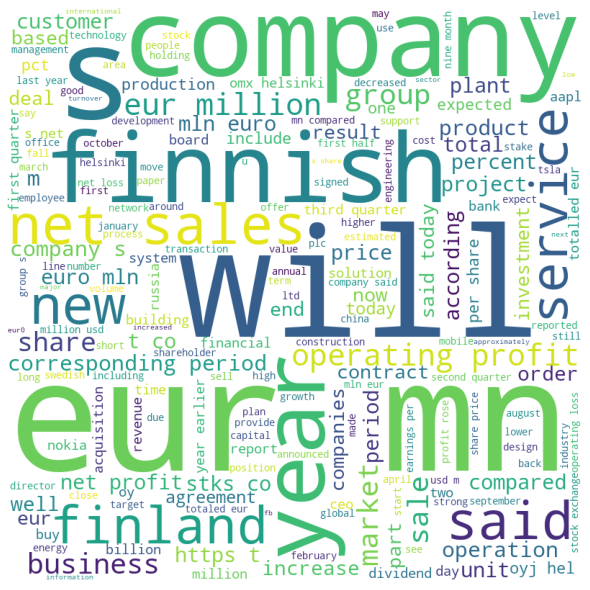

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.Sentence:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()